# TODO list fra mandag d. 24/4 kl.15:36

Jeg skal fikse/finde ud af hvordna de der k-vektor fungere med class og Kn.

Mit indtryk er at jeg bliver nød til at kalde class rigtig mange mange gange og der lyder lidt uhyggeligt.

Så få fat i Thomas eller Emil.


$\ddot{D}+\mathcal{H}\dot{D}-\frac{3}{2}\frac{H_0^2\Omega_m}{a}D=0$

$(\mathcal{H}\dot{D}D+\ddot{D}D+2\dot{D}^2)b_-+(4D\dot{D}+\mathcal{H}D^2)\dot{b}_-+2D^2\ddot{b}_-=\frac{3}{2}H_0^2 \Omega_m\frac{D^2}{a}$

For now let us assume equilateral configurations, thsi means $k_1\sim k_2 \sim k_3 \rightarrow \hat{k}_1 \cdot\hat{k}_2 = |k|^2 \cos(60^{\circ})=\frac{1}{2}|k|^2 $ 



In [2]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time

cs(1)=0.00019477974533539888
1.0005970149253731e-07 100.0597014925373
END


Exception ignored in: Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable
'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable
Exception ignored in: Traceback (most recent call last):
'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable
TypeError: argument of type 'NoneType' is not iterable
Traceback (most recent call last):
Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable
  File "classy.pyx", line 208, in classy.Class.struct_clea

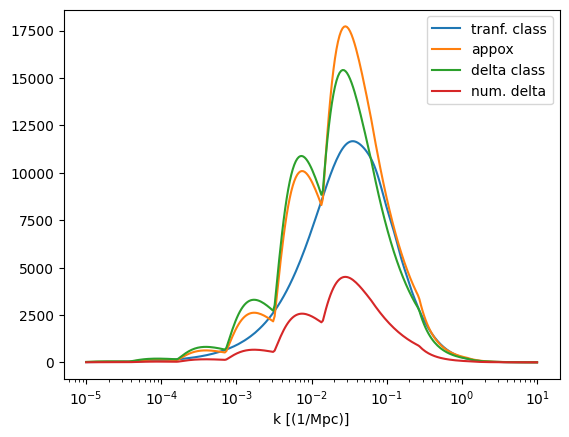

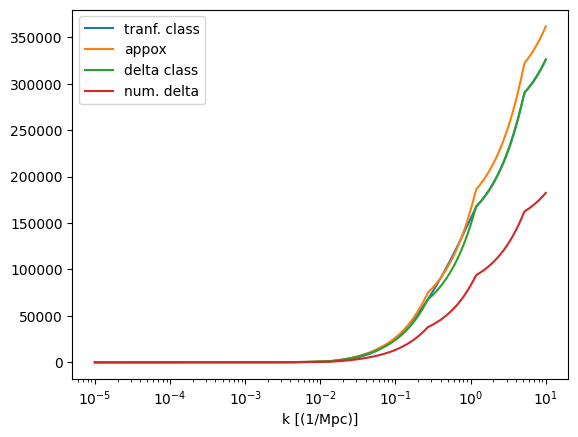

In [65]:
def TEST(kvec=[1],k_ind=0,z=800,mv_test=1 ,   Omega_M = 0.3,Omega_b=0.05,PLOT_FIGUR=True,div_med_a=False,EdSitter=True):

    if EdSitter==True:
        Omega_M = 0.95
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 #,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl,mPk', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    tid = bg['proper time [Gyr]'] * c / 306.4 # det kommer af Gyrs * c = 306.4 Mpc
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    T = cosmo.get_transfer_and_k_and_z
    T = cosmo.pk
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    k_sup = tranf['k (h/Mpc)'] * h
    
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    


    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T0 / a / mv

    print(f"{cs(1)=}")
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)

    D = np.empty(len(kvec))
    delta_approx=np.empty(len(kvec))
    delta_test = np.empty(len(kvec))
    for kind,k_T in enumerate(kvec):
        delta_class = pts[kind]["delta_cdm"]
        theta_class = pts[kind]["theta_cdm"]
        tau_class = pts[kind]["tau [Mpc]"]
        a_class = pts[kind]["a"]
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
        delta_interp = scipy.interpolate.interp1d(tau_class,delta_class)
        theta_interp = scipy.interpolate.interp1d(tau_class,theta_class)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class)
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tau_from_a(a0))
        delta0 = delta_interp(T0)
        t0 = tau_class[-1]
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100)
        def Dfunc(tau,y):
            a = a_interp(tau)
            D = y[0]
            dD = y[1]
            d2D = - H(a) * dD + (3/2) * H0*H0 * Omega_M * D / a
            b = y[2]
            db = y[3]
            d2b = 1/(2*D*D) * (3/2 * H0**2 * Omega_M * D**2 /a - (H(a)*dD*D+d2D*D+2*dD**2)*b - (4*D*dD+H(a)*dD**2)*db)
            return [dD,d2D,db,d2b]

        start0 = [delta_interp(T0),theta_interp(T0),0,0]
        sol = sc.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        
        #b = scipy.interpolate.interp1d(sol.t,-sol.y[2])
        #t = sol.t
        D[kind] = sol.y[0][-1]
        #print("D-delta0/a0a = %.2f" %(D(t0)-delta0/a0)) # der var lige lidt forvirring over hvorfor de ligger så tæt 
        # på hinanden så jeg printede forskellen, jeg tror måske der er ngoet fishy men det kna godt være at den er ok
        delta_approx[kind] = delta0/a0 * 1
        delta_test[kind] = delta_class[-1]
    
        
    """plt.figure(np.random.randint(1,1111111))
    plt.loglog(sol.t,-sol.y[0])
    z = 1/(1/4 * H0**2 * sol.t**2) - 1
    plt.loglog(tau_class,-delta_class)
    plt.figure(np.random.randint(1,1111111))
    """
    
    print(min(k_sup),max(k_sup))
    
    Dapprox = scipy.interpolate.interp1d(kvec,delta_approx)
    Dtest = scipy.interpolate.interp1d(kvec,delta_test)
    DD =  scipy.interpolate.interp1d(kvec,D)
    
    pDapprox = lambda k: 2*np.pi**2 * Dapprox(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    pDtest = lambda k: 2*np.pi**2 * Dtest(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    pDD = lambda k: 2*np.pi**2 * DD(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    kvec = np.logspace(-5,1,300)
    #kvec = np.linspace(1e-5,10,300)
    plt.plot(kvec,p(kvec),label="tranf. class")
    plt.plot(kvec,pDapprox(kvec),label="appox")
    plt.plot(kvec,pDtest(kvec),label="delta class")
    plt.semilogx(kvec,pDD(kvec),label="num. delta")
    plt.legend()
    plt.xlabel("k [(1/Mpc)]")
    plt.figure(np.random.randint(1,1111111))
    
    plt.plot(kvec,-d_m_af_k(kvec),label="tranf. class")
    plt.plot(kvec,-Dapprox(kvec),label="appox")
    plt.plot(kvec,-Dtest(kvec),label="delta class")
    plt.semilogx(kvec,-DD(kvec),label="num. delta")
    plt.legend()
    plt.xlabel("k [(1/Mpc)]")
    #P = np.array([T(0.1,u) for u in k_sup])
    #print(P)
    #plt.loglog(k_sup,-P)
    
    print("END")
kvec = list(np.logspace(-7,2,15))
TEST(kvec=kvec)